#유희왕 카드 문자 판별하기

이번 프로젝트는 OCR이라는 기술을 활용하여 유희왕 카드 문자를 읽어

몬스터, 마법, 함정 카드를 제대로 분류할 수 있는지 확인해보겠습니다.

OCR 모델로는 3가지를 사용할것입니다.

1. Google Clound Vision API
2. Tesseract
3. keras-ocr

위의 3가지 모델을 한번씩 사용해보고 어떤 모델이 가장 좋은 성능을 보이는지

또는 어떠한 점에서 두드러지는 성능을 보여주는지 확인해보겠습니다.

<br/>

☝목차 

📚사전 준비

📚다운 받은 데이터 시각화

📚Google Clound Vision API

📚keras-OCR

📚Tesseract

📚Tesseract - 문자 검출, 이미지 자르기 함수

📚crop한 문자이미지를 확인해보겠습니다.

📚Google Clound Vision API vs Keras-ocr

📚마무리

##사전 준비
###라이브러리 설치 및 임포트

In [ ]:
!pip install keras_ocr

In [ ]:
!pip install pytesseract

In [ ]:
!sudo apt install tesseract-ocr
!sudo apt install libtesseract-dev

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as img
import keras_ocr

import pytesseract
from PIL import Image
from pytesseract import Output

import warnings
warnings.filterwarnings("ignore")

---

##다운 받은 데이터 시각화

dir라는 변수에 다운받은 사진이 있는 경로의 주소를 리스트 형식으로 넣어줍니다.

그다음으로 plt.imshow를 사용하여 그 경로에 있는 파일을 이미지로 보여줍니다.

In [77]:
dir = '/content/drive/MyDrive/pic/ex/'
cards = glob(dir + '*.jpg')
cards.sort()
cards[:3]

['/content/drive/MyDrive/pic/ex/1.jpg',
 '/content/drive/MyDrive/pic/ex/10.jpg',
 '/content/drive/MyDrive/pic/ex/11.jpg']

In [4]:
plt.figure(figsize=(20,20))

for idx, im in enumerate(cards):
    plt.subplot(3, 4, idx+1)
    im = img.imread(im)
    plt.imshow(im)
    plt.axis('off')

Output hidden; open in https://colab.research.google.com to view.

---

##Google Cloud Vision API

첫번째로는 구글의 클라우드 기반 OCR API를 사용해서 문자를 인식해보겠습니다.

In [ ]:
!pip install google-cloud-vision

In [ ]:
!pip install protobuf

In [7]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [8]:
# 로컬 환경에서는 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
# 클라우드 환경에서는 무시해도 좋습니다
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = '/content/drive/MyDrive/pic/ex/hoppak_api.json'

# 입력 이미지 경로를 지정해 주세요.
# (예시) path = os.getenv('HOME')+'/aiffel/ocr_python/test_image.png'
path = '/content/drive/MyDrive/pic/ex/10.jpg'

# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
detect_text(path)

total 8
drwx------ 5 root root 4096 Jun 16 05:18 drive
drwxr-xr-x 1 root root 4096 Jun  1 13:50 sample_data
Texts:

"SERRA
A
[SPELL CARD 69]
SILENT GRAVEYARD
ARE
3E份
按摩
CARDOC.CO.KR
GALERINIZ
Discardi cart, effects that activate in the GT this turnare neganed.
$3278234 Edition
019% KAZURI TAKAHASHI
15"

"SERRA"

"A"

"["

"SPELL"

"CARD"

"69"

"]"

"SILENT"

"GRAVEYARD"

"ARE"

"3E"

"份"

"按摩"

"CARDOC.CO.KR"

"GALERINIZ"

"Discardi"

"cart"

","

"effects"

"that"

"activate"

"in"

"the"

"GT"

"this"

"turnare"

"neganed"

"."

"$"

"3278234"

"Edition"

"019"

"%"

"KAZURI"

"TAKAHASHI"

"15"
bounds: (159,93),(164,116),(150,120),(144,96)


글씨와 심지어 한자 같은 부분도 상당히 잘 분리가 이루어지는 걸 확인해볼수 있습니다.

---

##keras - OCR

두번째로는 keras API기반의 OCR를 사용해보겠습니다.

End-to-End 방식을 사용합니다.



```
pipeline = keras_ocr.pipeline.Pipeline()
```
위에 코드를 사용하는 이유는
- 인식을 위한 파이프라인을 생성하고 미리 학습된 가중치를 불러옵니다.
- 검출과 인식을 위한 가중치를 하나씩 불러옵니다.



```
recognize()
```
- 바운딩 박스를 생성하여, 그안에 있는 문자를 인식하는 과정을 거친다.


In [9]:
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /root/.keras-ocr/craft_mlt_25k.h5
Looking for /root/.keras-ocr/crnn_kurapan.h5


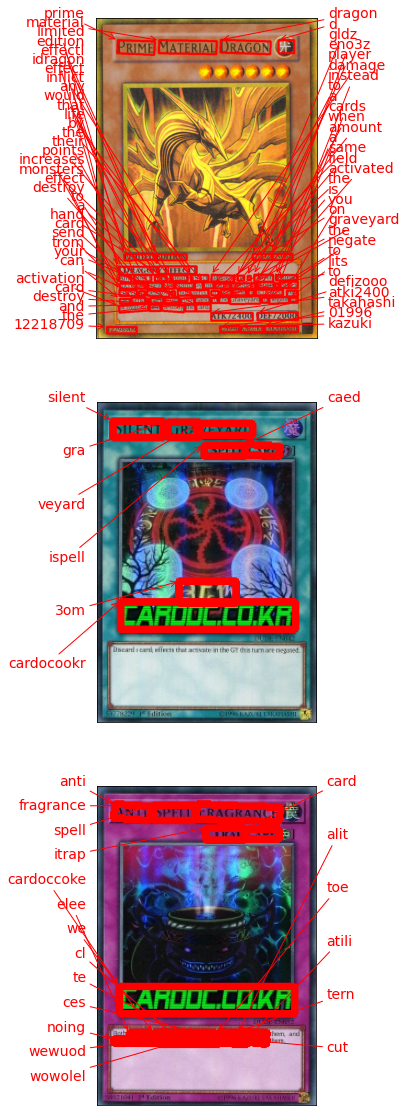

In [10]:
images = [ keras_ocr.tools.read(card) for card in cards]
prediction_groups = [pipeline.recognize([card]) for card in cards]

fig, axs = plt.subplots(nrows = 3, figsize=(20, 20))
for idx, ax in enumerate(axs):
  if idx < 3:
    keras_ocr.tools.drawAnnotations(image=images[idx], predictions=prediction_groups[idx][0], ax=ax)

글씨를 분석해주는 능력은 google보다는 떨어지지만 한자 즉, 영어외에는 분류를 못할 것으로 느껴집니다.

하지만 이미지와 같이 보여주고 있어 글씨만 보여주는것 보다는 좋다고 느껴집니다.  

---

##Tesseract

Tesseract는 구글에서 후원하는 문자판별(OCR) 라이브러리 입니다.

Tesseract 활용한 서비스를 이용하기전에 사전에 준비해야하는 과정이 있습니다.

<BR/>


1.Tesseract는 설치를 진행하고 구동하셔야됩니다.


```
!sudo apt install tesseract-ocr
!sudo apt install libtesseract-dev
```
<BR/>

2.Tesseract wrapper 설치

Pytesseract라는 Tesseract wrapper는 OS에 설치된 Tesseract를 파이썬에서 쉽게 사용할수있도록 해줍니다.

또한, Tesseract는 한국어 지원까지 가능합니다.

##Tesseract - 문자 검출, 이미지 자르기 함수

/content/drive/MyDrive/pic/ex/0000.png
/content/drive/MyDrive/pic/ex/0001.png
/content/drive/MyDrive/pic/ex/0002.png
/content/drive/MyDrive/pic/ex/0003.png
/content/drive/MyDrive/pic/ex/0004.png
/content/drive/MyDrive/pic/ex/0005.png
/content/drive/MyDrive/pic/ex/0006.png
/content/drive/MyDrive/pic/ex/0007.png
/content/drive/MyDrive/pic/ex/0008.png
/content/drive/MyDrive/pic/ex/0009.png
/content/drive/MyDrive/pic/ex/0010.png
/content/drive/MyDrive/pic/ex/0011.png
/content/drive/MyDrive/pic/ex/0012.png
/content/drive/MyDrive/pic/ex/0013.png
/content/drive/MyDrive/pic/ex/0014.png
/content/drive/MyDrive/pic/ex/0015.png
/content/drive/MyDrive/pic/ex/0016.png
/content/drive/MyDrive/pic/ex/0017.png
/content/drive/MyDrive/pic/ex/0018.png
/content/drive/MyDrive/pic/ex/0019.png
/content/drive/MyDrive/pic/ex/0020.png
/content/drive/MyDrive/pic/ex/0021.png
/content/drive/MyDrive/pic/ex/0022.png
/content/drive/MyDrive/pic/ex/0023.png
/content/drive/MyDrive/pic/ex/0024.png
/content/drive/MyDrive/pi

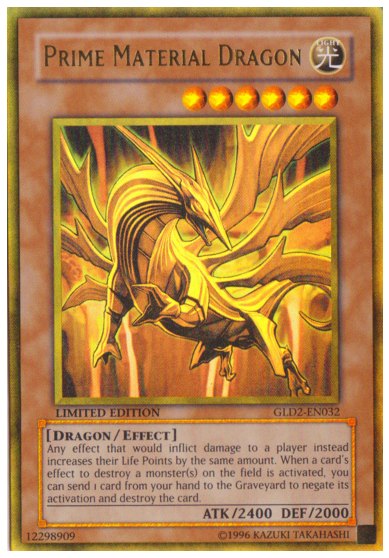

In [85]:
#이미지를 받아서, 문자를 검출한 후, 검출된 문자 영역을 crop한 이미지로 만들어 그 파일들의 list를 리턴
def crop_word_regions(image_path='./content/drive/MyDrive/pic/ex/sample.png', output_path='./sample'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    #pytesseract의 Output을 사용해서 결과값의 형식을 딕셔너리 형식으로 설정
    #인식된 결과가 recognized_data에 저장, 바운딩 박스의 left, top, width, height 정보
    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

plt.figure(figsize = (10, 10))

im = img.imread('/content/drive/MyDrive/pic/ex/1.jpg')
plt.imshow(im)
plt.axis('off')

work_dir = '/content/drive/MyDrive/pic/ex'
img_file_path = work_dir + '/1.jpg'

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

In [86]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

| DRAGON

/

KPFEC

_—

tnat

would

mic

damaee

i()

cl

player

instead oF

-

lite

Points

DY

ine

Scll

mount

Wher

lad

card s

POY

a

monster(s)

ii

1 The

. field

is

activated.

yOu

a

send

|

cara

irom

YOU!

‘hance

| t¢

» the

Graveyarc

1 TO

neegat

eC 1TS

activation

Ary

dg destroy

I


Done


##crop한 문자이미지를 확인해보겠습니다.

위에서 분류한 글자를 확인해보니 제대로 인식을 못하거나 이상한 문자로 나타난것도 보입니다.

실제로 글씨가 어떻게 나와있는지 crop한 이미지를 확인해보겠습니다.

In [46]:
import numpy as np

random_idx = np.random.choice(np.arange(len(cropped_image_path_list)), 5, replace=False)
cropped_image_pahts = []
for idx in random_idx:
    cropped_image_pahts.append(cropped_image_path_list[idx])
cropped_image_pahts

recognize_images(cropped_image_pahts)

. field

| DRAGON

irom

Points

cara

Done


. field

Done


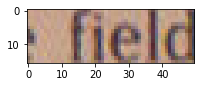

| DRAGON

Done


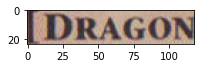

irom

Done


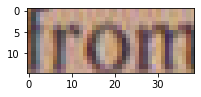

Points

Done


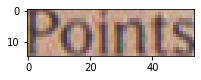

cara

Done


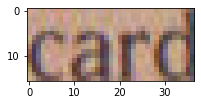

In [47]:
for i in range(5) :
    plt.figure(figsize = (3, 3))
    pil_img = Image.open(cropped_image_pahts[i])
    recognize_images([cropped_image_pahts[i]])
    plt.imshow(pil_img)
    plt.show()

실제로 잘린 이미지에서 결과를 뽑아본 결과 육안으로 확인이 가능하지만 이상하게 인식한것도 몇가지가 보입니다.

특히 card를 인식에서는 cara로 보여집니다.

또한 파일을 자르고 그에 맞게 이미지를 저장하고 다시 확인하는게 매우 비효율적으로 느껴집니다.

효율과 정확성 둘다 최저인거 같습니다.

따라서 Tesseract는 가장 최하위로 두고 나머지 두개를 비교해보겠습니다.

##Google Cloud Vision API vs Keras-ocr

Google Cloud Vision API과 Keras-ocr이 두 모델이 가장 좋아보여서 한번 비교해보겠습니다.

In [ ]:
dir1 = '/content/drive/MyDrive/pic/ex/'
card1 = os.listdir(dir1)
card1

In [87]:
def diff(card):
  print('keras-OCR==========================================================================')
  idx = card1.index(card)
  keras_ocr.tools.drawAnnotations(image=images[idx], predictions=prediction_groups[idx][0])
  plt.show()
  print('google-OCR==========================================================================')
  detect_text(os.path.join(dir1, card))

keras-OCR==========================================================================


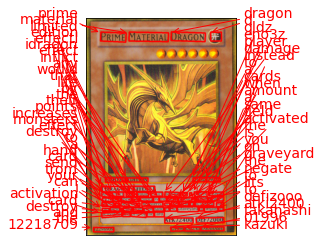

google-OCR==========================================================================
Texts:

"HITOTSU-ME GIANT
[BEAST-WARRIOR]
on nem is at penti
ATK/1200 DEF/1000
GENKATILDIRKAHAN"

"HITOTSU"

"-"

"ME"

"GIANT"

"["

"BEAST"

"-"

"WARRIOR"

"]"

"on"

"nem"

"is"

"at"

"penti"

"ATK"

"/"

"1200"

"DEF"

"/"

"1000"

"GENKATILDIRKAHAN"
bounds: (110,270),(174,269),(174,275),(110,276)
keras-OCR==========================================================================


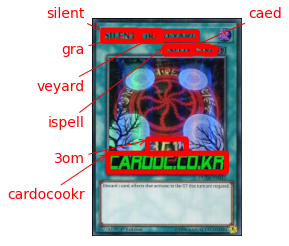

google-OCR==========================================================================
Texts:

"LIGHT
PRIME MATERIAL DRAGON GE
LIMITED EDITION
GLD2-EN032
[DRAGON/EFFECT]
Any effect that would inflict damage to a player instead
increases their Life Points by the same amount. When a card's
effect to destroy a monster(s) on the field is activated, you
can send i card from your hand to the Graveyard to negate its
activation and destroy the card.
ATK/2400 DEF/2000
12298909
©1996 KAZUKI TAKAHASHI"

"LIGHT"

"PRIME"

"MATERIAL"

"DRAGON"

"GE"

"LIMITED"

"EDITION"

"GLD2"

"-"

"EN032"

"["

"DRAGON"

"/"

"EFFECT"

"]"

"Any"

"effect"

"that"

"would"

"inflict"

"damage"

"to"

"a"

"player"

"instead"

"increases"

"their"

"Life"

"Points"

"by"

"the"

"same"

"amount"

"."

"When"

"a"

"card's"

"effect"

"to"

"destroy"

"a"

"monster"

"("

"s"

")"

"on"

"the"

"field"

"is"

"activated"

","

"you"

"can"

"send"

"i"

"card"

"from"

"your"

"hand"

"to"

"the"

"Graveyard"

"to"

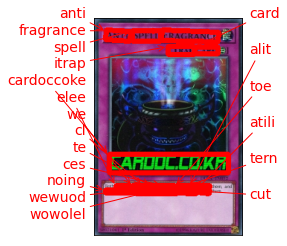

google-OCR==========================================================================
Texts:

"DODGER DRAGON 嵐
www
www.tcgshop.co.kr
1st Edition
EXVC-EN082
[DRAGON/EFFECT]
The Normal Summon of this card cannot be negated. Your
opponent cannot activate Counter Trap Cards the turn this card
is Normal Summoned.
ATK/1900 DEF/1200
47013502
HEN
OKT
1996 KAZUKI TAKAHASHI WOR
نا"

"DODGER"

"DRAGON"

"嵐"

"www"

"www.tcgshop.co.kr"

"1st"

"Edition"

"EXVC"

"-"

"EN082"

"["

"DRAGON"

"/"

"EFFECT"

"]"

"The"

"Normal"

"Summon"

"of"

"this"

"card"

"cannot"

"be"

"negated"

"."

"Your"

"opponent"

"cannot"

"activate"

"Counter"

"Trap"

"Cards"

"the"

"turn"

"this"

"card"

"is"

"Normal"

"Summoned"

"."

"ATK"

"/"

"1900"

"DEF"

"/"

"1200"

"47013502"

"HEN"

"OKT"

"1996"

"KAZUKI"

"TAKAHASHI"

"WOR"

"نا"
bounds: (319,486),(335,486),(335,491),(319,491)
keras-OCR==========================================================================


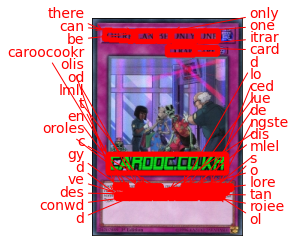

google-OCR==========================================================================
Texts:

"MOBIUS THE FROST MONARCH
LIMITED EDITION
GID2-ENDO7
[AQUA/EFFECT]
When this card is Tribute Summoned, you can destroy up to a
Spell or Trap Cards on the field
ATK/2400 DEF/1000
©1996 KAZUKI TAKAHASHI"

"MOBIUS"

"THE"

"FROST"

"MONARCH"

"LIMITED"

"EDITION"

"GID2"

"-"

"ENDO7"

"["

"AQUA"

"/"

"EFFECT"

"]"

"When"

"this"

"card"

"is"

"Tribute"

"Summoned"

","

"you"

"can"

"destroy"

"up"

"to"

"a"

"Spell"

"or"

"Trap"

"Cards"

"on"

"the"

"field"

"ATK"

"/"

"2400"

"DEF"

"/"

"1000"

"©"

"1996"

"KAZUKI"

"TAKAHASHI"
bounds: (152,284),(182,284),(182,288),(152,288)
keras-OCR==========================================================================


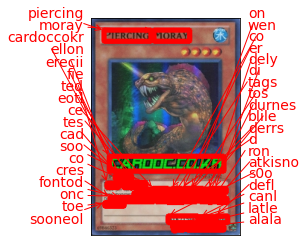

google-OCR==========================================================================
Texts:

"GE
RAI-MEI
1 Edition
CSOC-ENDRS
[THUNDER/EFFECT]
When this card is destroyed by battle and sent to the
Graveyard, you can add 1 Level 2 or lower LIGHT monster from
your Deck to your hand.
ATK/1400 DEF/1200
63223467
1996 KAZUKI TAKAHASHI"

"GE"

"RAI"

"-"

"MEI"

"1"

"Edition"

"CSOC"

"-"

"ENDRS"

"["

"THUNDER"

"/"

"EFFECT"

"]"

"When"

"this"

"card"

"is"

"destroyed"

"by"

"battle"

"and"

"sent"

"to"

"the"

"Graveyard"

","

"you"

"can"

"add"

"1"

"Level"

"2"

"or"

"lower"

"LIGHT"

"monster"

"from"

"your"

"Deck"

"to"

"your"

"hand"

"."

"ATK"

"/"

"1400"

"DEF"

"/"

"1200"

"63223467"

"1996"

"KAZUKI"

"TAKAHASHI"
bounds: (225,416),(270,416),(270,423),(225,423)
keras-OCR==========================================================================


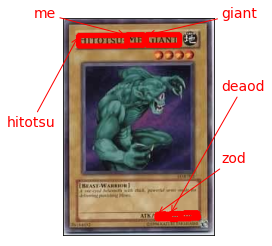

google-OCR==========================================================================
Texts:

"SISHUNDER
免
Edition
BITUINGI
THUNDER/EFFECT]
When this card is Normal Summoned You can target i Level 4
LIGHT Thunder Type monster with too or less ATK in your
Graveyard, except Sishunder banish that target During the
End Phase of this tum, add that card to your hand
ATK/ 900 DEF/ 400
57019473
1996
KAZUO TAKAHASHI"

"SISHUNDER"

"免"

"Edition"

"BITUINGI"

"THUNDER"

"/"

"EFFECT"

"]"

"When"

"this"

"card"

"is"

"Normal"

"Summoned"

"You"

"can"

"target"

"i"

"Level"

"4"

"LIGHT"

"Thunder"

"Type"

"monster"

"with"

"too"

"or"

"less"

"ATK"

"in"

"your"

"Graveyard"

","

"except"

"Sishunder"

"banish"

"that"

"target"

"During"

"the"

"End"

"Phase"

"of"

"this"

"tum"

","

"add"

"that"

"card"

"to"

"your"

"hand"

"ATK"

"/"

"900"

"DEF"

"/"

"400"

"57019473"

"1996"

"KAZUO"

"TAKAHASHI"
bounds: (149,277),(179,277),(179,282),(149,282)
keras-OCR=======================

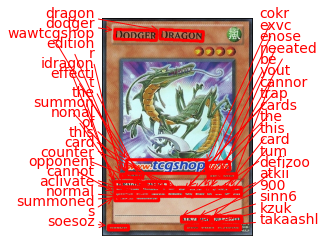

google-OCR==========================================================================
Texts:

"MAHUNDER
-Edition
DUENYS
THUNDER/EFFECT]
Once per turn: You can Normal Summon Level 45
LIGHT Thunder-Type monster from your hand, except
"Mahunder", as an additional Normal Summon.
ATK/1400 DEF/ 700
019% KAZUKI TAKAHAS
21524779"

"MAHUNDER"

"-Edition"

"DUENYS"

"THUNDER"

"/"

"EFFECT"

"]"

"Once"

"per"

"turn"

":"

"You"

"can"

"Normal"

"Summon"

"Level"

"45"

"LIGHT"

"Thunder"

"-"

"Type"

"monster"

"from"

"your"

"hand"

","

"except"

"""

"Mahunder"

"""

","

"as"

"an"

"additional"

"Normal"

"Summon"

"."

"ATK"

"/"

"1400"

"DEF"

"/"

"700"

"019"

"%"

"KAZUKI"

"TAKAHAS"

"21524779"
bounds: (8,335),(39,334),(39,341),(8,342)
keras-OCR==========================================================================


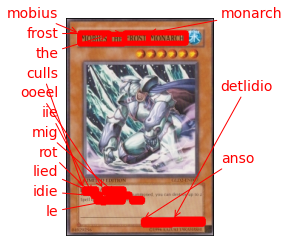

google-OCR==========================================================================
Texts:

"PAHUNDER
GE
-Edition
KIDEENOX
[THUNDER/EFFECT]
Once per tum You can Normal Summon Level 4
LIGHT Thunder-Type monster from your hand, except
"Pahunder", as an additional Normal Summon
ATK/1300 DEF/ 600
84530620
€1996 KAZURI TAKAHASHI
WH"

"PAHUNDER"

"GE"

"-Edition"

"KIDEENOX"

"["

"THUNDER"

"/"

"EFFECT"

"]"

"Once"

"per"

"tum"

"You"

"can"

"Normal"

"Summon"

"Level"

"4"

"LIGHT"

"Thunder"

"-"

"Type"

"monster"

"from"

"your"

"hand"

","

"except"

"""

"Pahunder"

"""

","

"as"

"an"

"additional"

"Normal"

"Summon"

"ATK"

"/"

"1300"

"DEF"

"/"

"600"

"84530620"

"€"

"1996"

"KAZURI"

"TAKAHASHI"

"WH"
bounds: (184,278),(190,278),(190,280),(184,280)
keras-OCR==========================================================================


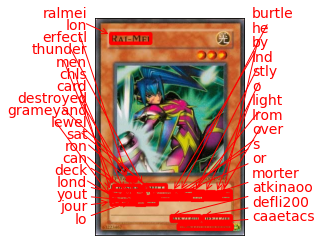

google-OCR==========================================================================
Texts:

"SERRA
A
[SPELL CARD 69]
SILENT GRAVEYARD
ARE
3E份
按摩
CARDOC.CO.KR
GALERINIZ
Discardi cart, effects that activate in the GT this turnare neganed.
$3278234 Edition
019% KAZURI TAKAHASHI
15"

"SERRA"

"A"

"["

"SPELL"

"CARD"

"69"

"]"

"SILENT"

"GRAVEYARD"

"ARE"

"3E"

"份"

"按摩"

"CARDOC.CO.KR"

"GALERINIZ"

"Discardi"

"cart"

","

"effects"

"that"

"activate"

"in"

"the"

"GT"

"this"

"turnare"

"neganed"

"."

"$"

"3278234"

"Edition"

"019"

"%"

"KAZURI"

"TAKAHASHI"

"15"
bounds: (159,93),(164,116),(150,120),(144,96)
keras-OCR==========================================================================


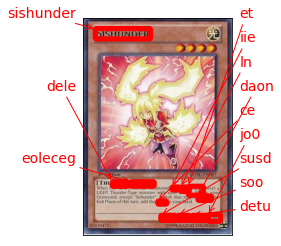

google-OCR==========================================================================
Texts:

"ANTI-SPELL FRAGRANCE
[TRAP CARD
CARDOC.CO.KR
Both players must Set Spell Cards before activating them, anal
cannot activate them until their next tam after Setting them.
58921041 Edition
19% KAZURI TAKAHASHI"

"ANTI"

"-"

"SPELL"

"FRAGRANCE"

"["

"TRAP"

"CARD"

"CARDOC.CO.KR"

"Both"

"players"

"must"

"Set"

"Spell"

"Cards"

"before"

"activating"

"them"

","

"anal"

"cannot"

"activate"

"them"

"until"

"their"

"next"

"tam"

"after"

"Setting"

"them"

"."

"58921041"

"Edition"

"19"

"%"

"KAZURI"

"TAKAHASHI"
bounds: (150,284),(181,284),(181,288),(150,288)
keras-OCR==========================================================================


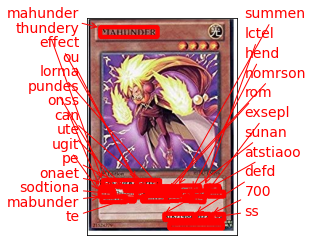

google-OCR==========================================================================
Texts:

"THERE CAN BE ONLY ONE
[TRAP CARD
CARDOC.CO.KR
TOUTE PNICE
Each player can only controle monster of rach Type. If a player
controls 2 or more inorsters of the same Type, they must send
some to the GY so they control no more than i monster of that
Type
242117501 Edition"

"THERE"

"CAN"

"BE"

"ONLY"

"ONE"

"["

"TRAP"

"CARD"

"CARDOC.CO.KR"

"TOUTE"

"PNICE"

"Each"

"player"

"can"

"only"

"controle"

"monster"

"of"

"rach"

"Type"

"."

"If"

"a"

"player"

"controls"

"2"

"or"

"more"

"inorsters"

"of"

"the"

"same"

"Type"

","

"they"

"must"

"send"

"some"

"to"

"the"

"GY"

"so"

"they"

"control"

"no"

"more"

"than"

"i"

"monster"

"of"

"that"

"Type"

"242117501"

"Edition"
bounds: (45,281),(66,281),(66,284),(45,284)
keras-OCR==========================================================================


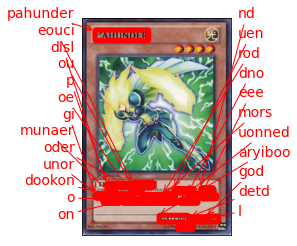

google-OCR==========================================================================
Texts:

"PIERCING MORAY
GR
CARDOC.CO.KR
1 Edition
GENE-EN082
[FISH/EFFECT]
Once per tum You can Tribute Fish Sea Serpent, or Aqua-
Type monster; this card gains 600 ATK. If this card attacks a
Defense Position monster, inflict piercing Battle Damage to your
opponent.
ATK/1500 DEF/ 500
1996 KAZUKI TAKAHASH
69846323"

"PIERCING"

"MORAY"

"GR"

"CARDOC.CO.KR"

"1"

"Edition"

"GENE"

"-"

"EN082"

"["

"FISH"

"/"

"EFFECT"

"]"

"Once"

"per"

"tum"

"You"

"can"

"Tribute"

"Fish"

"Sea"

"Serpent"

","

"or"

"Aqua"

"Type"

"monster"

";"

"this"

"card"

"gains"

"600"

"ATK"

"."

"If"

"this"

"card"

"attacks"

"a"

"Defense"

"Position"

"monster"

","

"inflict"

"piercing"

"Battle"

"Damage"

"to"

"your"

"opponent"

"."

"ATK"

"/"

"1500"

"DEF"

"/"

"500"

"1996"

"KAZUKI"

"TAKAHASH"

"69846323"
bounds: (8,280),(32,280),(32,284),(8,284)


In [88]:
for card in card1:
  diff(card)

글씨만 분석하는 능력은 확실히 google이 뛰어나보입니다.

---

##마무리

유희왕 카드를 종류에 따라 분류해보는 방향으로 진행하였습니다.

유희왕은 카드배틀을 소재한 일본의 오컬트, 판타지 만화입니다.

여기서 카드란 몬스터 카드, 마법 카드, 함정 카드로 나뉘어집니다.

각각 종류에 따라 쓰는 방법과 활용법도 다릅니다.

그러므로 카드를 종류와 키워드에 맞게 분류할 수 있다면 10만장이 넘는 유희왕카드에서 관련 카드를 찾기 쉬워지고

카드 덱도 빨리 만들 수 있지 않을까란 생각을 가지고 만들어 보았습니다.

이번 프로젝트에서 가장 좋은 모델은 제 생각으로는 google, keras가 가장 좋고 teseract가 가장 안좋았습니다.

또한 google, keras도 용도에 따라 1위 2위가 바뀔 수 있다고 생각합니다.

google은 글씨분석 능력이 가장 뛰어나지만 사진으로 표현해주지 못합니다.

kares는 글씨분석은 google보다 떨어지지만 사진과 글씨를 같이 보여주고 있습니다.

유희왕 카드 기준에서는 키워드가 겹칠수도 있어서 사진을 보면서 비교도 해야한다고 생각합니다.

즉, 유희왕 카드 기준으로는 google보다 keras가 더 좋게 적용될수도 있습니다.

하지만 글씨만 분류해도 상관이 없다면 google이 keras보다 좋게 적용된다고 생각합니다.

따라서 향후 과제로는 kares-ocr 형식으로 보여주지만 글씨 분석능력은 google정도 수준을 보여주는 모델을 만들면 좋을꺼 같습니다.

<br/>

어려웠던점

1. 함수가 통일이 되어있지 않아 어려웠다.
2. file 전처리가 생각보다 어려웠다.
3. Google Clound Vision API가 실행할때마다 오류가 떠서 힘들었다.
4. 라이브러리 설치시 오류가 많이 발생했다.

<br/>

아쉬웠던 점

1. API구조를 몰라 자유자재로 사용하지 못했다.
2. 함수를 통일하지 못한 점이 아쉽다.
3. 함수 구조를 많이 바꿔보지 못한것이 아쉬웠다.